## Import necessary functions and connect to the sql server

In [260]:
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
install("pyodbc")

import pyodbc

server = 'tcp:mcruebs04.isad.isadroot.ex.ac.uk' 
database = 'BEMM459_GroupI'
username = 'GroupI' 
password = 'UufS373+To'

serverstring = 'DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+password+';TrustServerCertificate=yes;Encrypt=no;'
cnxn = pyodbc.connect(serverstring)
cursor = cnxn.cursor()

## Cells to update data in each sql table

In [261]:
### Pandas to insert command ###
# Prepare INSERT statement
def prepare_insert_statement(df, table_name):
    columns = df.columns.tolist()
    placeholders = ', '.join(['?'] * len(columns))  # ODBC uses ? instead of %s
    columns_sql = ', '.join(f'[{col}]' for col in columns)
    insert_sql = f"INSERT INTO {table_name} ({columns_sql}) VALUES "
    data_tuples = [tuple(row) for row in df.to_numpy()]
    drop_statement = 'TRUNCATE TABLE '+table_name+' '
    statement = drop_statement+insert_sql+', '.join([str(t) for t in data_tuples])+';'
    return statement

############################### Loading in excel files onto SQL Tables ###############################

def excel_to_table (file_path, table_name):
    df = pd.read_excel(file_path)
    insert_statement = prepare_insert_statement(df, table_name)
    #print(insert_statement)
    cursor.execute(insert_statement)
    # Use commit to get it to finish 
    cnxn.commit()
    
# customers extended data
customers_extended_data_file_path = r'C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\customers_extended_data.xlsx'
excel_to_table(customers_extended_data_file_path, 'customers_extended_data') 

#fresh products data
fresh_products_data_file_path = r'C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\fresh_products_with_vendors.xlsx'
excel_to_table(fresh_products_data_file_path, 'fresh_products_data')

#order details data
order_details_data_file_path = r'C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\order_details_data.xlsx'
excel_to_table(order_details_data_file_path, 'order_details_data')

#stores data
stores_data_file_path = r'C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\stores_data.xlsx'
excel_to_table(stores_data_file_path, 'stores_data')

#inventory data
updated_inventory_fresh_new_data_file_path = r'C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\updated_inventory_fresh_new_data.xlsx'
excel_to_table(updated_inventory_fresh_new_data_file_path, 'updated_inventory_fresh_new_data')


In [264]:
### Pandas to insert command ###
# Prepare INSERT statement
def prepare_insert_statement(df, table_name):
    columns = df.columns.tolist()
    placeholders = ', '.join(['?'] * len(columns))  # ODBC uses ? instead of %s
    columns_sql = ', '.join(f'[{col}]' for col in columns)
    insert_sql = f"INSERT INTO {table_name} ({columns_sql}) VALUES ({placeholders})"
    
    # Convert DataFrame to a list of tuples for parameterized query
    data_tuples = [tuple(row) for row in df.to_numpy()]
    
    return insert_sql, data_tuples

############################### Loading in excel files onto SQL Tables ###############################

def excel_to_table(file_path, table_name):
    df = pd.read_excel(file_path)
    
    # Handle timestamp columns by converting to datetime strings
    for col in df.select_dtypes(include=['datetime64']).columns:
        df[col] = df[col].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    insert_sql, data_tuples = prepare_insert_statement(df, table_name)
    
    # Truncate table first
    cursor.execute(f'TRUNCATE TABLE {table_name}')
    
    # Use parameterized query to avoid SQL injection and formatting issues
    cursor.executemany(insert_sql, data_tuples)
    
    # Use commit to get it to finish 
    cnxn.commit()

#orders final data
orders_final_data_file_path = r"C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\orders_final_data.xlsx"
excel_to_table(orders_final_data_file_path, 'orders_final_data')

## MongoDB data management

### Writing into mongodb

In [ ]:
from datetime import datetime

file_path = r"C:\Users\LENOVO\Documents\M.Sc Business Analytics\Term 2\Database Technologies BEMM459\Group I Tables\customer_reviews.xlsx"
reviews_df = pd.read_excel(file_path)

#converting dataframe to a list of dictionaries
records = reviews_df.to_dict(orient="records")

#convert review_date to datetime
for record in records:
    record["product_name"] = {
        "product_name": record.pop("product_name"),
        "category": record.pop("category")
    }
    record["review_date"] = datetime.strptime(record["review_date"], "%Y-%m-%d")

#connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["BEMM459_GroupI"]
collection = db["customer_reviews"]

#insert documents
collection.insert_many(records)

print("Customer reviews successfully inserted into MongoDB.")


### Clearing mangodb database to update data

In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Choose your database
db = client["BEMM459_GroupI"]

# Drop all collections in the database
for collection_name in db.list_collection_names():
    db.drop_collection(collection_name)

print("All collections dropped. Database is now empty.")

# Data extractions and Operations

In [276]:
# Load the correct tables based on your database
orders_df = pd.read_sql("SELECT * FROM orders_final_data", cnxn)
inventory_df = pd.read_sql("SELECT * FROM updated_inventory_fresh_new_data", cnxn)
order_details_df = pd.read_sql("SELECT * FROM order_details_data", cnxn)
products_df = pd.read_sql("SELECT * FROM fresh_products_data", cnxn)
stores_df = pd.read_sql("SELECT * FROM stores_data", cnxn)
customers_df = pd.read_sql("SELECT * FROM customers_extended_data", cnxn)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\3394960665.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql("SELECT * FROM orders_final_data", cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\3394960665.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inventory_df = pd.read_sql("SELECT * FROM updated_inventory_fresh_new_data", cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\3394960665.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql("SELECT 

### 1. Which stores produced the most late deliveries? 

In [268]:

#Late deliceries and store details form orders final
late_deliveries_query="SELECT order_completion, store_id FROM orders_final_data;"
late_deliveries_df = pd.read_sql(late_deliveries_query, cnxn)

#store id and name from stores_data
store_id_and_name_query="SELECT store_id, store_name FROM stores_data;"
store_id_and_name_df = pd.read_sql(store_id_and_name_query, cnxn)

#add store name to each store id
late_deliveries_df = late_deliveries_df.merge(
    store_id_and_name_df,
    on='store_id',
    how='left'  # Keeps all late deliveries, adds store_name where store_id matches
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\1776268700.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  late_deliveries_df = pd.read_sql(late_deliveries_query, cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\1776268700.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  store_id_and_name_df = pd.read_sql(store_id_and_name_query, cnxn)


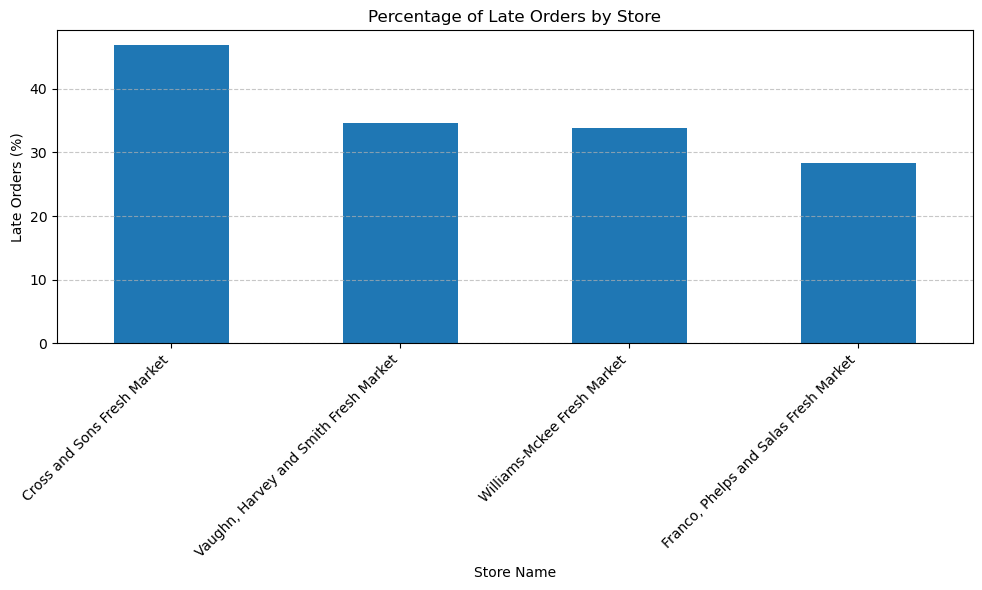

In [270]:
# Total orders per store
total_orders = late_deliveries_df.groupby("store_name").size()

# Late orders per store
late_orders = late_deliveries_df[late_deliveries_df["order_completion"] == "Late"]
late_counts = late_orders.groupby("store_name").size()

# Calculate percentage
late_percentage = (late_counts / total_orders * 100).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
late_percentage.plot(kind='bar')
plt.title("Percentage of Late Orders by Store")
plt.xlabel("Store Name")
plt.ylabel("Late Orders (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 2. Finding the customers that have spent the most in our stores and printing their emails to send them discount coupons

In [272]:
# Step 1: Load customer_id and total_amount from orders_final_data
query_orders = """
SELECT customer_id, total_amount
FROM orders_final_data
"""
orders_df = pd.read_sql(query_orders, cnxn)

# Step 2: Calculate total spend per customer
customer_spend_df = orders_df.groupby('customer_id', as_index=False)['total_amount'].sum()
customer_spend_df.rename(columns={'total_amount': 'total_spend'}, inplace=True)

# Step 3: Load customer details from customers_extended_data
query_customers = """
SELECT customer_id, first_name, last_name, email
FROM customers_extended_data
"""
customers_df = pd.read_sql(query_customers, cnxn)

# Step 4: Merge customer details with spend data
full_df = customer_spend_df.merge(customers_df, on='customer_id', how='left')

# Step 5: Get top 10 customers by spend
top_10_customers = full_df.sort_values(by='total_spend', ascending=False).head(10)

# Step 6: Display their names and emails to then send them discount codes
result = top_10_customers[['first_name', 'last_name', 'email', 'total_spend']]
print("Details of customers to mail discount coupons to:")
print(result)

Details of customers to mail discount coupons to:
   first_name  last_name                    email  total_spend
29       Eric      Brown        grant06@gmail.com       451.13
42     Wesley  Dickerson    brockjoseph@gmail.com       434.81
71  Francisco      Brown      joshua32@galvan.com       426.01
77   Jennifer     Taylor   thomasnathan@gmail.com       425.88
15    Destiny      White  vickiesimmons@yahoo.com       418.07
27      Julie    Jackson    marcwilkins@gmail.com       414.13
82     Robert      Giles       robert58@yahoo.com       353.18
11      Sarah    Carroll      rdeleon@hotmail.com       348.08
70     Steven    Daniels    stephanie12@gmail.com       325.11
54      Craig      Baker       jthomas@gordon.org       311.88


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\109228660.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql(query_orders, cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\109228660.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers_df = pd.read_sql(query_customers, cnxn)


### 3. Find the most popular products for each month


 Top 5 Products in 2025-01:



,product_name,quantity
14,Broccoli,46
12,Grapes,43
13,Mango,37
15,Blueberry,36
6,Orange,36


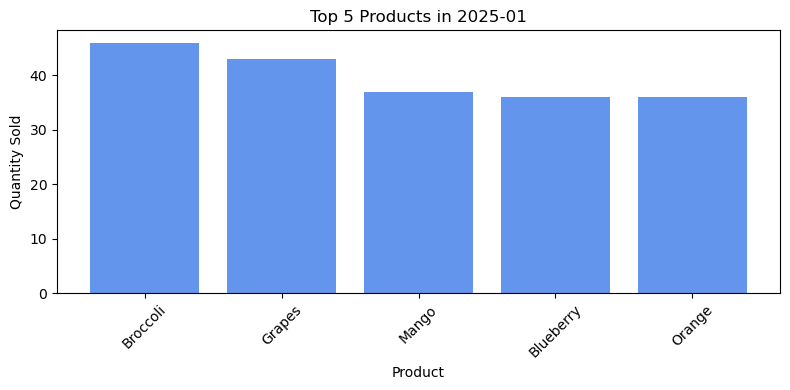


 Top 5 Products in 2025-02:



,product_name,quantity
36,Pineapple,42
21,Banana,33
35,Garlic,31
30,Bell Pepper,30
29,Onion,28


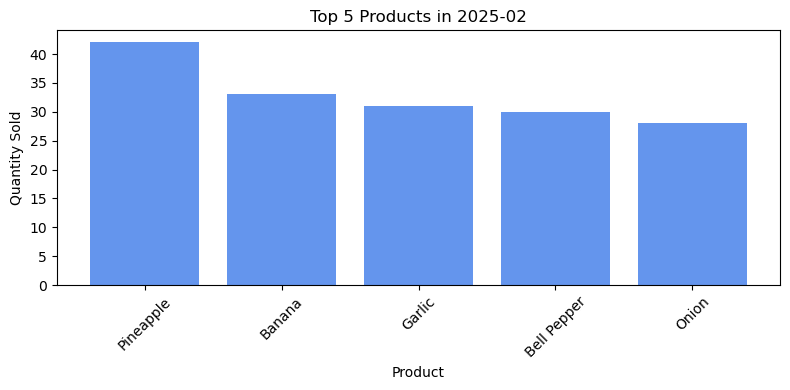


 Top 5 Products in 2025-03:



,product_name,quantity
45,Spinach,33
41,Tomato,32
43,Orange,32
53,Avocado,32
48,Grapes,18


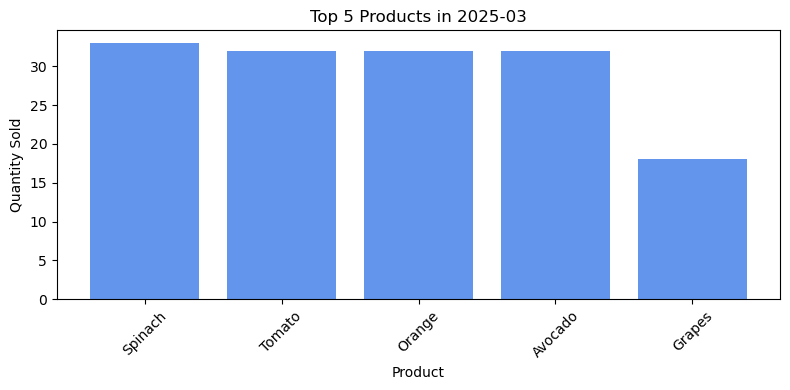

In [278]:
import matplotlib.pyplot as plt

# Step 1: Merge order details with order dates
order_details_with_date = order_details_df.merge(
    orders_df[['order_id', 'order_date']],
    on='order_id',
    how='left'
)

# Step 2: Convert to datetime and extract month
order_details_with_date['order_date'] = pd.to_datetime(order_details_with_date['order_date'])
order_details_with_date['order_month'] = order_details_with_date['order_date'].dt.to_period('M')

# Step 3: Aggregate quantity per product per month
monthly_sales = (
    order_details_with_date.groupby(['order_month', 'product_id'])['quantity']
    .sum()
    .reset_index()
)

# Step 4: Merge with product names
monthly_sales_named = monthly_sales.merge(
    products_df[['product_id', 'product_name']],
    on='product_id',
    how='left'
).dropna(subset=['product_name'])

# Step 5: For each month, get Top 5 products, show table and graph
unique_months = monthly_sales_named['order_month'].unique()

for month in unique_months:
    top5 = monthly_sales_named[monthly_sales_named['order_month'] == month]\
        .sort_values(by='quantity', ascending=False)\
        .head(5)

    print(f"\n Top 5 Products in {month}:\n")
    display(top5[['product_name', 'quantity']])

    # Plot graph
    plt.figure(figsize=(8, 4))
    plt.bar(top5['product_name'], top5['quantity'], color='cornflowerblue')
    plt.title(f"Top 5 Products in {month}")
    plt.xlabel("Product")
    plt.ylabel("Quantity Sold")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 4.	Use customer address (longitude and latitude) to assign them to nearest store

In [280]:
install("geopy")

In [281]:
from geopy.distance import geodesic

# Step 1: Define a function that calculates the nearest store based on geodesic distance
def get_nearest_store(lat, lon):
    distances = stores_df.apply(
        lambda row: geodesic((lat, lon), (row['latitude'], row['longitude'])).km,
        axis=1
    )
    nearest_store_id = stores_df.loc[distances.idxmin(), 'store_id']
    return nearest_store_id

# Step 2: Apply the function to each customer
customers_df['nearest_store_id'] = customers_df.apply(
    lambda row: get_nearest_store(row['latitude'], row['longitude']),
    axis=1
)

# Step 3: Display sample results
print(" Sample of customers with their nearest store:")
display(customers_df[['customer_id', 'latitude', 'longitude', 'nearest_store_id']].head())


 Sample of customers with their nearest store:


,customer_id,latitude,longitude,nearest_store_id
0,1,85.788515,-57.504298,101
1,2,89.255510,-23.394247,101
2,3,-44.475197,83.424788,104
3,4,74.635570,-44.549804,101
4,5,29.355314,46.858404,103


### 5. Highlight any products within a week of their sell-by-date

In [284]:
from datetime import datetime

# Step 1: Convert sell_by_date to datetime
products_df['sell_by_date'] = pd.to_datetime(products_df['sell_by_date'])

# Step 2: Merge inventory with product details to bring in sell_by_date
inventory_with_dates = inventory_df.merge(
    products_df[['product_id', 'product_name', 'sell_by_date']],
    on='product_id',
    how='left'
)

#  Step 3: Set a fixed reference date
today = datetime.strptime("2025-03-17", "%Y-%m-%d")

# Step 4: Filter products expiring within 7 days from the fixed date
expiring_soon_df = inventory_with_dates[
    (inventory_with_dates['sell_by_date'] - today).dt.days <= 7
]

# Step 5: Show result
print(" Products within 7 days of sell-by date (as of 2025-03-17):")
display(expiring_soon_df[['product_id', 'product_name', 'store_id', 'stock_quantity', 'sell_by_date']])


 Products within 7 days of sell-by date (as of 2025-03-17):


,product_id,product_name,store_id,stock_quantity,sell_by_date
1,217,Garlic,102,69,2025-03-23
2,208,Potato,103,90,2025-03-24
3,208,Potato,101,263,2025-03-24
4,214,Mango,104,298,2025-03-24
5,204,Lettuce,101,333,2025-03-21
...,...,...,...,...,...
93,208,Potato,101,261,2025-03-24
95,210,Spinach,103,347,2025-03-22
96,213,Grapes,101,181,2025-03-20
97,208,Potato,104,315,2025-03-24


### 6. Find items below re-order threshold in each store

In [286]:
# Step 1: Load the necessary tables
inventory_df = pd.read_sql("SELECT inventory_id, store_id, product_id, stock_quantity, reorder_threshold FROM updated_inventory_fresh_new_data", cnxn)
stores_df = pd.read_sql("SELECT store_id, store_name FROM stores_data", cnxn)
products_df = pd.read_sql("SELECT product_id, product_name, vendor FROM fresh_products_data", cnxn)

# Step 2: Filter inventory where stock is below threshold
low_stock_df = inventory_df[inventory_df["stock_quantity"] < inventory_df["reorder_threshold"]]

# Step 3: Merge with stores_data to get store_name
low_stock_df = low_stock_df.merge(stores_df, on="store_id", how="left")

# Step 5: Merge with products_df to get product_name and vendor
low_stock_df = low_stock_df.merge(products_df, on="product_id", how="left")

# Step 6: Final columns for output
result_df = low_stock_df[["inventory_id", "store_id", "store_name", "product_id", "product_name", "vendor", "stock_quantity", "reorder_threshold"]]
# Optional: Display
print("Products below re-order threshold")
print(result_df)


Products below re-order threshold
   inventory_id  store_id                             store_name  product_id  \
0          5023       102  Franco, Phelps and Salas Fresh Market         218   
1          5067       103  Vaughn, Harvey and Smith Fresh Market         218   
2          5072       101            Cross and Sons Fresh Market         210   
3          5077       104            Williams-Mckee Fresh Market         217   

  product_name          vendor  stock_quantity  reorder_threshold  
0    Pineapple      Farm2Table              16                 23  
1    Pineapple      Farm2Table              30                 39  
2      Spinach  UrbanFresh Co.              18                 46  
3       Garlic     PureGrocers              23                 26  


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\825228204.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inventory_df = pd.read_sql("SELECT inventory_id, store_id, product_id, stock_quantity, reorder_threshold FROM updated_inventory_fresh_new_data", cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\825228204.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stores_df = pd.read_sql("SELECT store_id, store_name FROM stores_data", cnxn)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\825228204.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not teste

### 7. Printing a list of customer emails to offer reimbursements to

In [288]:
# Step 1: Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["BEMM459_GroupI"]
collection = db["customer_reviews"]

# Step 2: Fetch reviews with rating = 1
one_star_reviews = list(collection.find({"rating": 1}))

# Step 3: Convert to DataFrame
one_star_rating_df = pd.DataFrame(one_star_reviews)

# Step 4: Load customer details from SQL table
query = """
SELECT customer_id, first_name, last_name, email
FROM customers_extended_data
"""
customers_df = pd.read_sql(query, cnxn)

# Step 5: Merge on customer_id
reimbursement_df = one_star_rating_df.merge(customers_df, on="customer_id", how="left")

# Step 6: Select the necessary fields
reimbursement_df = reimbursement_df[["customer_id", "first_name", "last_name", "email"]].drop_duplicates()

# Step 7: Display
print("Customers to offer reimbursements to:")
print(reimbursement_df)

Customers to offer reimbursements to:
   customer_id first_name last_name                    email
0           32      Julie   Jackson    marcwilkins@gmail.com
1           19    Destiny     White  vickiesimmons@yahoo.com
2           96     Robert     Giles       robert58@yahoo.com
3           24      Emily     Ortiz      amartinez@yahoo.com
4           49    Heather     Allen  farrellpaul@wheeler.com


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19124\4199202496.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers_df = pd.read_sql(query, cnxn)


### 8. Compare the amount of low ratings recieved by each vendor

In [290]:
# Step 1: Extract 'product_name' from nested dict
reviews_df["product_name_str"] = reviews_df["product_name"].apply(
    lambda x: x.get("product_name") if isinstance(x, dict) else None
)

# Step 2: Create a flag for low ratings (1 or 2 stars)
reviews_df["is_low_rating"] = reviews_df["rating"].isin([1, 2])

# Step 3: Group and calculate low rating percentage at product level
product_stats = reviews_df.groupby("product_name_str").agg(
    total_reviews=("rating", "count"),
    low_rating_count=("is_low_rating", "sum")
).reset_index()

product_stats["low_rating_percent"] = (
    product_stats["low_rating_count"] / product_stats["total_reviews"] * 100
).round(2)

# Step 4: Merge vendor info
product_stats = product_stats.merge(
    products_df[["product_name", "vendor"]],
    left_on="product_name_str",
    right_on="product_name",
    how="left"
)

# Step 5: Sort and display
product_stats = product_stats.sort_values(by="low_rating_percent", ascending=False)

print("Products with Highest % of Low Ratings (1 or 2 stars):")
print(product_stats[["product_name_str", "vendor", "low_rating_percent", "total_reviews"]])


Products with Highest % of Low Ratings (1 or 2 stars):
   product_name_str             vendor  low_rating_percent  total_reviews
6            Carrot  GreenHarvest Ltd.               100.0              1
12            Onion  GreenHarvest Ltd.                50.0              2
18           Tomato         Farm2Table                50.0              2
2            Banana  GreenHarvest Ltd.                40.0              5
5          Broccoli     UrbanFresh Co.                25.0              4
0             Apple        PureGrocers                 0.0              2
17       Strawberry  GreenHarvest Ltd.                 0.0              4
16          Spinach     UrbanFresh Co.                 0.0              1
15           Potato     Natures Basket                 0.0              2
14        Pineapple         Farm2Table                 0.0              1
13           Orange         Farm2Table                 0.0              1
10          Lettuce     Natures Basket                 0.

In [292]:
# Step 1: Merge review data with product info to get vendor
merged_df = reviews_df.merge(
    products_df[["product_name", "vendor"]],
    left_on="product_name_str",
    right_on="product_name",
    how="left"
)

# Step 2: Group by vendor and calculate low rating stats
vendor_stats = merged_df.groupby("vendor").agg(
    total_reviews=("rating", "count"),
    low_rating_count=("is_low_rating", "sum")
).reset_index()

vendor_stats["low_rating_percent"] = (
    vendor_stats["low_rating_count"] / vendor_stats["total_reviews"] * 100
).round(2)

# Step 3: Sort and display
vendor_stats = vendor_stats.sort_values(by="low_rating_percent", ascending=False)

print("Vendors with Highest % of Low Ratings (1 or 2 stars):")
print(vendor_stats[["vendor", "low_rating_percent", "total_reviews"]])

Vendors with Highest % of Low Ratings (1 or 2 stars):
              vendor  low_rating_percent  total_reviews
1  GreenHarvest Ltd.               28.57             14
4     UrbanFresh Co.               20.00              5
0         Farm2Table               12.50              8
2     Natures Basket                0.00              8
3        PureGrocers                0.00             15
